In [44]:
import cv2
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import wandb

from collections import Counter, defaultdict
from pathlib import Path
from tqdm import tqdm

import params

In [2]:
DATA_PATH = Path('../data/')
TRAIN_DATA = DATA_PATH / 'multilabel_classification' / 'train.csv'
CATEGORY_KEYS = DATA_PATH / 'category_key.csv'
TRAIN_ANNOTATIONS = DATA_PATH / 'object_detection' / 'train.json'
EVAL_ANNOTATIONS = DATA_PATH / 'object_detection' / 'eval.json'
IMAGES_PATH = DATA_PATH / 'images'

In [3]:
train_data = pd.read_csv(TRAIN_DATA).set_index('id')
train_data.head()

,categories
id,
3b6f01ae-5bde-434d-9b06-79b269421ed6,[1.0]
dce21f7c-20e5-482b-bd90-c038f8464c03,[1.0]
4a7f2199-772d-486d-b8e2-b651246316b5,[1.0]
3bddedf6-4ff8-4e81-876a-564d2b03b364,"[1.0, 9.0, 11.0, 88.0]"
3f735021-f5de-4168-b139-74bf2859d12a,"[1.0, 37.0, 51.0, 119.0]"


In [4]:
category_keys = pd.read_csv(CATEGORY_KEYS).set_index('id')
category_keys.head()

,name,supercat
id,,
1,Actiniaria,Anemone
2,Actinernus,Anemone
3,Actiniidae,Anemone
4,Actinoscyphia,Anemone
5,Bolocera,Anemone


In [6]:
print(f'Number of all categories: {category_keys.shape[0]}')

Number of all categories: 290


In [7]:
with open(TRAIN_ANNOTATIONS, 'r') as f:
    train_annos = json.load(f)

In [8]:
for image_path in IMAGES_PATH.glob('*.png'):
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    break

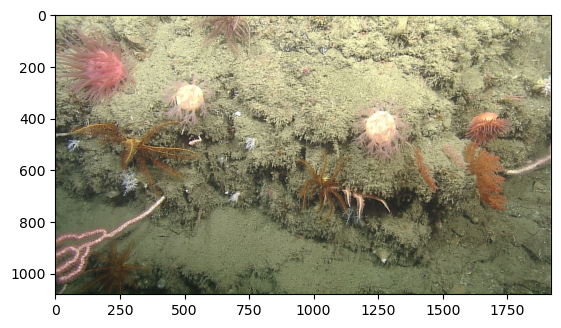

In [9]:
plt.imshow(image)

In [10]:
id2cat = {row['id']: row['name'] for row in train_annos['categories']}
labels = [id2cat[idx] for idx in sorted(id2cat.keys())]
columns=['file_name', *[f'p{i}' for i in range(1, 6)], 'images', 'dataset']
columns

['file_name', 'p1', 'p2', 'p3', 'p4', 'p5', 'images', 'dataset']

In [11]:
train_annos['annotations'][0]

{'id': 1,
 'image_id': 1,
 'category_id': 1.0,
 'segmentation': [],
 'area': 7869.0,
 'bbox': [347.0, 188.0, 129.0, 61.0],
 'iscrowd': 0}

In [12]:
train_annos['images'][0]

{'id': 1,
 'width': 720,
 'height': 368,
 'file_name': '3b6f01ae-5bde-434d-9b06-79b269421ed6.png',
 'license': 0,
 'flickr_url': 'https://fathomnet.org/static/m3/framegrabs/Tiburon/images/1120/03_50_15_04.png',
 'coco_url': 'https://fathomnet.org/static/m3/framegrabs/Tiburon/images/1120/03_50_15_04.png',
 'date_captured': '2007-08-17 17:50:34'}

In [13]:
def create_table(data: dict, is_debug=False):
    """Create a data table
    
    :param data: coco-formatted dataset with images and corresponding bounding boxes
    :return: populated table with 6 + number of labels columns
    :rtype: wandb.Table
    """
    
    def convert_bbox(bbox):
        """Convert a bbox from COCO format to top-left, bottom-right coords
        
        :param bbox: bounding box; top left corner, width and height
        :type bbox: [int, int, int, int]
        :return: top-left and bottom-right corners
        :rtype: [int, int, int, int]
        """

        x, y, w, h = bbox
        return int(x), int(y), int(x + w), int(y + h)
    
    id2cat = {row['id']: row['name'] for row in data['categories']}
    labels = [id2cat[idx] for idx in sorted(id2cat.keys())]
    table = wandb.Table(
        columns=['file_name', 'images', 'image_width', 'image_height', 'nr_objects', 'split'] + labels
    )
    images = data['images']
    if is_debug:
        images = images[:10]
    for pos, image_data in tqdm(enumerate(images)):
        file_name = IMAGES_PATH / image_data['file_name']
        image = cv2.imread(str(file_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]
        
        image_id = image_data['id']
        image_annos = [anno for anno in data['annotations'] if anno['image_id'] == image_id]
        bboxes = []
        categories = []
        for anno in image_annos:
            x1, y1, x2, y2 = convert_bbox(anno['bbox'])
            category_id = int(anno['category_id'])
            category = id2cat[category_id]
            
            categories.append(category)
            bboxes.append(
                {
                    'position': {
                        'minX': x1, 
                        'minY': y1,
                        'maxX': x2,
                        'maxY': y2
                    },
                    'domain': 'pixel', # bboxes are provided in the pixel space!
                    'class_id': category_id,
                    'box_caption': category
                }
            )
            
        observed_labels_count = Counter(categories)
        table.add_data(
            file_name.stem,
            wandb.Image(
                image,
                boxes={
                    'ground_truth': {
                        'box_data': bboxes,
                        'class_labels': id2cat
                    }
                }
            ),
            width,
            height,
            len(image_annos),
            None, # No split yet!
            *[observed_labels_count.get(label, 0) for label in labels]
        )

    return table

In [14]:
run = wandb.init(project=params.WANDB_PROJECT, entity=params.ENTITY, job_type='upload')

wandb: Currently logged in as: matt-zak. Use `wandb login --relogin` to force relogin


In [15]:
raw_data_at = wandb.Artifact(params.RAW_DATA_AT, type='raw_data')

In [16]:
raw_data_at.add_dir(IMAGES_PATH, 'images')

wandb: Adding directory to artifact (./../data/images)... Done. 9.9s


In [17]:
# check if all training images have an existing image
downloaded_images = set(str(image_path).split('/')[-1] for image_path in IMAGES_PATH.glob('*.png'))
train_images = set(image_data['file_name'] for image_data in train_annos['images'])

In [18]:
print(f'Number of missing samples: {len(train_images - downloaded_images)}')

Number of missing samples: 0


In [19]:
table = create_table(train_annos)

5950it [38:01,  2.61it/s]


In [20]:
raw_data_at.add(table, 'eda_table')

ArtifactManifestEntry(path='eda_table.table.json', digest='4SixkjaQxDrj4ZcBf4bRgA==', ref=None, birth_artifact_id=None, size=11265212, extra={}, local_path='/Users/matthewzak/Library/Application Support/wandb/artifacts/staging/tmpja0sgwey')

In [21]:
run.log_artifact(raw_data_at)

In [22]:
run.finish()

In [26]:
id2cat = {row['id']: row['name'] for row in train_annos['categories']}
label_occurence = Counter(
    [int(anno['category_id']) for anno in train_annos['annotations']]
)

In [31]:
print(f'We have {len(label_occurence)} labels')
print(f'{len(id2cat) - len(label_occurence)} labels do not appear in the dataset!')

We have 133 labels
157 labels do not appear in the dataset!


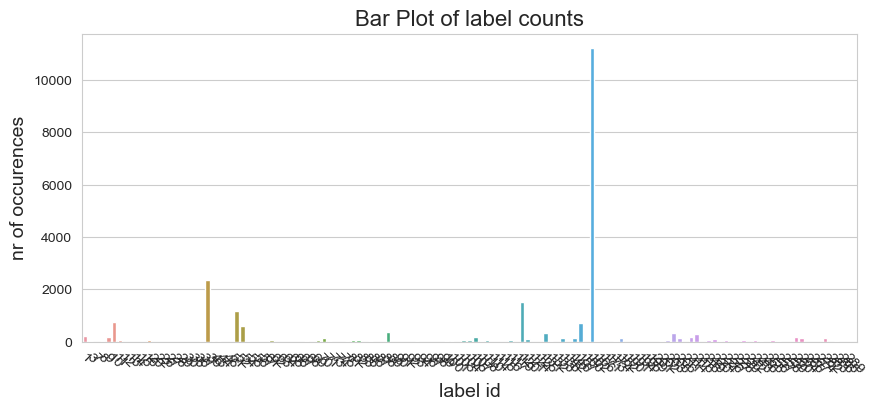

In [37]:
# Let's find out if we have labels with one occurence only
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10,4))

sns.barplot(x=list(label_occurence.keys()), y=list(label_occurence.values()), ax=ax)

plt.title("Bar Plot of label counts", fontsize=16)
plt.xlabel("label id", fontsize=14)
plt.xticks(rotation=-45)
plt.ylabel("nr of occurences", fontsize=14)
plt.show()

In [40]:
image_counts = defaultdict(lambda: 0)
for image_data in train_annos['images']:
    image_annos = [anno for anno in train_annos['annotations'] if anno['image_id'] == image_data['id']]
    unique_categories = np.unique([anno['category_id'] for anno in image_annos])
    for unique_category in unique_categories:
        image_counts[unique_category] += 1

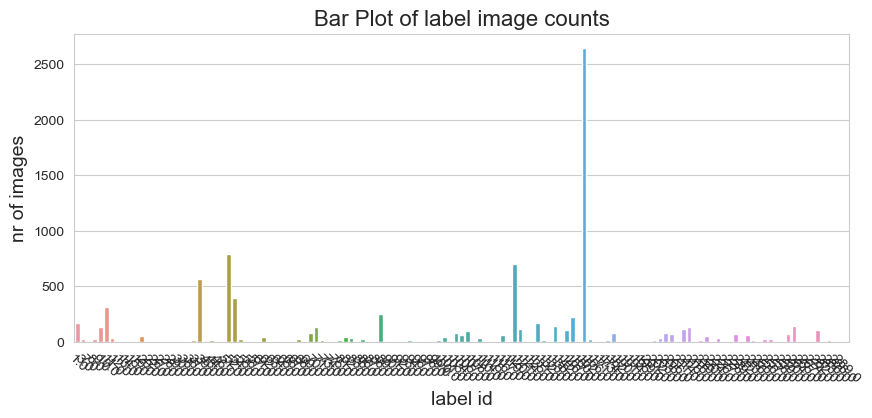

In [41]:
# Let's find out if we have labels with one occurence only
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10,4))

sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), ax=ax)

plt.title("Bar Plot of label image counts", fontsize=16)
plt.xlabel("label id", fontsize=14)
plt.xticks(rotation=-45)
plt.ylabel("nr of images", fontsize=14)
plt.show()

In [43]:
sum(image_counts.values())

9001